# Test Cartesian Laplacian with Land Mask

In [2]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import numpy as np
import cupy as cp
from dask.diagnostics import ProgressBar

import gcm_filters

### Open 1/8 degree NeverWorld2 data

In [37]:
run = 26 #1/8 deg
end_time = 31500

st = xr.open_dataset('/glade/p/univ/unyu0004/neerajab/NeverWorld2/run%i/static.nc' % (run), decode_times=False) 

chunks = {'time': 20} 
av = xr.open_dataset('/glade/p/univ/unyu0004/neerajab/NeverWorld2/run%i/averages_000%i.nc' % (run,end_time-500+2), 
                     chunks=chunks, decode_times=False)

In [40]:
wet_mask = st.wet

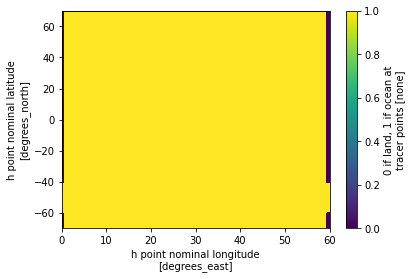

In [75]:
wet_mask.plot()

In [7]:
list(gcm_filters.GridType)

[<GridType.CARTESIAN: 1>,
 <GridType.CARTESIAN_WITH_LAND: 2>,
 <GridType.CARTESIAN_WITH_LAND_new: 3>]

We will test the speed of the Laplacian implementations under GridType 2 vs. 3. 

Both GridTypes have the same Laplacian implementation on a regular grid, but for GridType 3 (CARTESIAN_WITH_LAND_new) the computation of the wet_factor is moved to post_init, as suggested in this pull request: https://github.com/ocean-eddy-cpt/gcm-filters/pull/22

Hereafter, I will refer to the Laplacian implementation in 
* GridType 2 (CARTESIAN_WITH_LAND) as the "old" Laplacian, and 
* GridType 3 (CARTESIAN_WITH_LAND_new) as the "new" Laplacian.

## First: CPU with dask

In [68]:
filter = gcm_filters.Filter(
    filter_scale=4,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=8,
    grid_type=gcm_filters.GridType.CARTESIAN_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)
filter

Filter(filter_scale=4, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=8, grid_type=<GridType.CARTESIAN_WITH_LAND: 2>)

In [69]:
filter_new = gcm_filters.Filter(
    filter_scale=4,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=8,
    grid_type=gcm_filters.GridType.CARTESIAN_WITH_LAND_new,
    grid_vars={'wet_mask': wet_mask}
)
filter_new

Filter(filter_scale=4, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=8, grid_type=<GridType.CARTESIAN_WITH_LAND_new: 3>)

### We will test the speed of these 2 filters for the following 4D field

In [70]:
av.h

<xarray.DataArray 'h' (time: 100, zl: 15, yh: 1120, xh: 480)>
dask.array<open_dataset-dd984f45942772e19f542bb66c654fach, shape=(100, 15, 1120, 480), dtype=float32, chunksize=(20, 15, 1120, 480), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -69.94 -69.81 -69.69 -69.56 ... 69.69 69.81 69.94
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time     (time) float64 3.1e+04 3.101e+04 3.101e+04 ... 3.149e+04 3.15e+04
  * xh       (xh) float64 0.0625 0.1875 0.3125 0.4375 ... 59.69 59.81 59.94
Attributes:
    long_name:      Layer Thickness
    units:          m
    cell_methods:   area:mean zl:sum yh:mean xh:mean time: mean
    cell_measures:  area: area_t
    time_avg_info:  average_T1,average_T2,average_DT

## CPU

### Filter with old Laplacian

In [71]:
%time h_filtered = filter.apply(av.h, dims=['yh', 'xh'])

CPU times: user 6.96 ms, sys: 1.89 ms, total: 8.85 ms
Wall time: 8.34 ms


In [72]:
with ProgressBar():
    h_filtered.load()

[########################################] | 100% Completed |  3min 27.0s


### Filter with new Laplacian

In [73]:
%time h_filtered_new = filter_new.apply(av.h, dims=['yh', 'xh'])

CPU times: user 6.46 ms, sys: 2.18 ms, total: 8.64 ms
Wall time: 8.28 ms


In [74]:
with ProgressBar():
    h_filtered_new.load()

[########################################] | 100% Completed |  3min 25.8s


### Plot original and filtered fields

Text(0.5, 1.0, 'Difference between filtered fields')

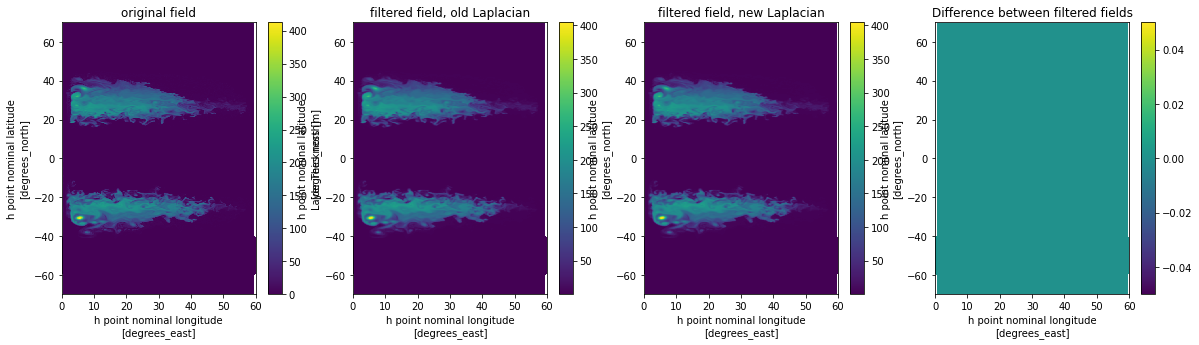

In [81]:
time = -1
layer = 0

fig,axs = plt.subplots(1,4,figsize=(20,5))
av.h.isel(time=time,zl=layer).plot(ax=axs[0])
axs[0].set_title('original field')
h_filtered.isel(time=time,zl=layer).plot(ax=axs[1])
axs[1].set_title('filtered field, old Laplacian')
h_filtered_new.isel(time=time,zl=layer).plot(ax=axs[2])
axs[2].set_title('filtered field, new Laplacian')
(h_filtered - h_filtered_new).isel(time=time,zl=layer).plot(ax=axs[3])
axs[3].set_title('Difference between filtered fields')

Text(0.5, 1.0, 'filtered field, old=new Laplacian')

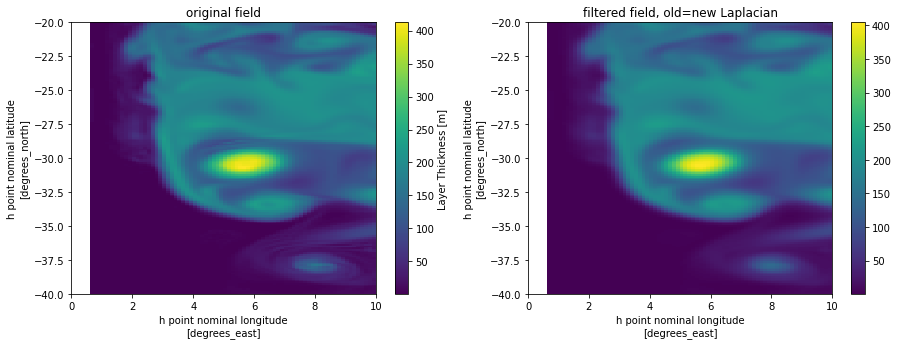

In [82]:
time = -1
layer = 0
xslice = slice(0,10)
yslice = slice(-40,-20)

fig,axs = plt.subplots(1,2,figsize=(15,5))
av.h.isel(time=time,zl=layer).sel(xh=xslice,yh=yslice).plot(ax=axs[0])
axs[0].set_title('original field')
h_filtered.isel(time=time,zl=layer).sel(xh=xslice,yh=yslice).plot(ax=axs[1])
axs[1].set_title('filtered field, old=new Laplacian')

## GPU

In [83]:
wet_mask = wet_mask.chunk({'yh': 1120,'xh': 480}) # 1 chunk

In [84]:
wet_mask_GPU = wet_mask.copy()
wet_mask_GPU

<xarray.DataArray 'wet' (yh: 1120, xh: 480)>
dask.array<copy, shape=(1120, 480), dtype=float64, chunksize=(1120, 480), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 0.0625 0.1875 0.3125 0.4375 ... 59.69 59.81 59.94
  * yh       (yh) float64 -69.94 -69.81 -69.69 -69.56 ... 69.69 69.81 69.94
Attributes:
    long_name:      0 if land, 1 if ocean at tracer points
    units:          none
    cell_methods:   time: point
    cell_measures:  area: area_t

In [85]:
wet_mask_GPU.data = wet_mask.data.map_blocks(cp.asarray)
wet_mask_GPU

<xarray.DataArray 'wet' (yh: 1120, xh: 480)>
dask.array<asarray, shape=(1120, 480), dtype=float64, chunksize=(1120, 480), chunktype=cupy.ndarray>
Coordinates:
  * xh       (xh) float64 0.0625 0.1875 0.3125 0.4375 ... 59.69 59.81 59.94
  * yh       (yh) float64 -69.94 -69.81 -69.69 -69.56 ... 69.69 69.81 69.94
Attributes:
    long_name:      0 if land, 1 if ocean at tracer points
    units:          none
    cell_methods:   time: point
    cell_measures:  area: area_t

In [91]:
h_GPU = av.h.copy()
h_GPU.data = h_GPU.data.map_blocks(cp.asarray)

In [92]:
filter_GPU = gcm_filters.Filter(
    filter_scale=4,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=8,
    grid_type=gcm_filters.GridType.CARTESIAN_WITH_LAND,
    grid_vars={'wet_mask': wet_mask_GPU}
)
filter_GPU

Filter(filter_scale=4, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=8, grid_type=<GridType.CARTESIAN_WITH_LAND: 2>)

In [93]:
filter_new_GPU = gcm_filters.Filter(
    filter_scale=4,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=8,
    grid_type=gcm_filters.GridType.CARTESIAN_WITH_LAND_new,
    grid_vars={'wet_mask': wet_mask_GPU}
)
filter_new_GPU

Filter(filter_scale=4, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=8, grid_type=<GridType.CARTESIAN_WITH_LAND_new: 3>)

## Filter with old Laplacian

In [94]:
%time h_filtered_GPU = filter_GPU.apply(h_GPU, dims=['yh', 'xh'])

CPU times: user 10.6 ms, sys: 2.7 ms, total: 13.3 ms
Wall time: 67.2 ms


In [95]:
with ProgressBar():
    h_filtered_GPU.load()

[########################################] | 100% Completed | 14.5s


### Filter with new Laplacian

In [101]:
%time h_filtered_new_GPU = filter_new_GPU.apply(h_GPU, dims=['yh', 'xh'])

CPU times: user 7.25 ms, sys: 1.21 ms, total: 8.46 ms
Wall time: 8.33 ms


In [102]:
with ProgressBar():
    h_filtered_new_GPU.load()

[########################################] | 100% Completed | 14.9s


### Summary

* "new" Laplacian implementation works on GPU, but is not faster
